In [1]:
# Inspired by https://towardsdatascience.com/basic-molecular-representation-for-machine-learning-b6be52e9ff76
from rdkit import Chem
import networkx as nx
from karateclub import Graph2Vec
import numpy as np
import pandas as pd
from rdkit.Chem import Draw
from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt
from karateclub import Graph2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense

In [2]:
# Read dataset
data = pd.read_csv('./HIV.csv')
data.head(10)

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0
5,CCOP(=O)(Nc1cccc(Cl)c1)OCC,CI,0
6,O=C(O)c1ccccc1O,CI,0
7,CC1=C2C(=COC(C)C2C)C(O)=C(C(=O)O)C1=O,CI,0
8,O=[N+]([O-])c1ccc(SSc2ccc([N+](=O)[O-])cc2[N+]...,CI,0
9,O=[N+]([O-])c1ccccc1SSc1ccccc1[N+](=O)[O-],CI,0


In [3]:
# Reading and drawing sample molecule
sample = data['smiles'][0]
mol = Chem.MolFromSmiles(sample)
Draw.MolToFile(mol, 'sample.png')
for i, atom in enumerate(mol.GetAtoms()):
    atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))
    
Draw.MolToFile(mol, 'sample_with_prop.png')

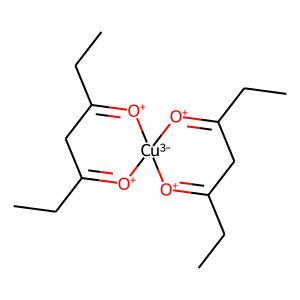

In [4]:
Image(filename='sample.png') 

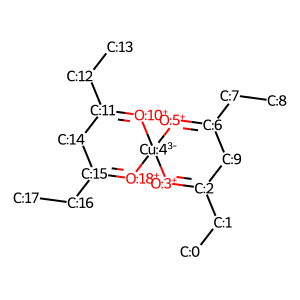

In [5]:
Image(filename='sample_with_prop.png')

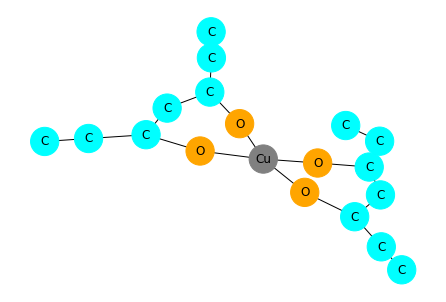

In [6]:
# Molecular Representation in Graph
sample = data['smiles'][0]
sample_mol = Chem.MolFromSmiles(sample)
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
        
    return G

sample_nx = mol_to_nx(sample_mol)
sample_atom = nx.get_node_attributes(sample_nx, 'atom_symbol')
color_map = {'C': 'cyan',
             'O': 'orange',
             'N': 'magenta'}  

graph_colors = []
for idx in sample_nx.nodes():
    if (sample_nx.nodes[idx]['atom_symbol'] in color_map):
        graph_colors.append(color_map[sample_nx.nodes[idx]['atom_symbol']])
    else:
        graph_colors.append('gray')
    
nx.draw(sample_nx,
        labels=sample_atom,
        with_labels = True,
        node_color=graph_colors,
        node_size=800)

plt.show()

In [7]:
print("Transform smiles to rdkit mol object")
data['mol'] = data['smiles'].apply(lambda x: Chem.MolFromSmiles(x))      
print("Create Networkx object from RDKit")
data['graph'] = data['mol'].apply(lambda x: mol_to_nx(x))
print("Create graph embedding")
model = Graph2Vec()
model.fit(data['graph'])
hiv_graph2vec = model.get_embedding()
hiv_graph2vec = pd.DataFrame(hiv_graph2vec)
hiv_graph2vec.head()

Transform smiles to rdkit mol object
Create Networkx object from RDKit
Create graph embedding


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.090017,-0.025276,0.009186,0.144655,-0.026491,-0.037248,-0.032797,-0.084750,-0.054650,-0.033314,...,-0.027615,-0.028252,-0.026290,-0.030576,0.048431,-0.021823,-0.144377,0.059747,0.097021,0.035418
1,0.069134,0.017155,0.052945,0.160981,0.049915,0.009456,-0.045622,-0.029025,-0.080332,-0.017462,...,-0.051398,-0.055297,-0.076094,-0.016771,0.041782,-0.002139,-0.146800,0.111925,0.094769,0.096508
2,-0.022203,0.065622,0.004288,0.137257,-0.026252,-0.097056,-0.000759,0.027776,-0.075071,-0.070744,...,0.027640,-0.017144,0.020173,-0.029443,-0.052433,0.017350,-0.085394,-0.020283,-0.015167,-0.091329
3,0.035615,0.094317,0.005448,-0.011407,0.117748,-0.000657,-0.051511,-0.078509,-0.098564,-0.104803,...,-0.097748,-0.048776,0.076120,-0.025367,-0.030122,-0.127232,-0.057834,0.003236,0.015567,-0.126875
4,0.045862,-0.054553,-0.026617,0.029091,0.113962,-0.040930,-0.007053,-0.067791,-0.030211,-0.055749,...,0.039236,-0.005336,0.096609,-0.030028,0.083408,-0.039091,-0.055249,0.049674,0.116016,-0.093649


In [8]:
# Data Balancing
print('Original imbalanced dataset')
print(data['HIV_active'].value_counts())

Original imbalanced dataset
0    40426
1     1487
Name: HIV_active, dtype: int64


In [9]:
# Data Balancing
X = hiv_graph2vec
y = data['HIV_active']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
print('Synthetic balanced dataset')
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Synthetic balanced dataset
0    40426
1    40426
Name: HIV_active, dtype: int64


In [10]:
# Data Balancing
X = hiv_graph2vec
y = data['HIV_active']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
print('Synthetic balanced dataset')
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Synthetic balanced dataset
0    40426
1    40426
Name: HIV_active, dtype: int64


In [13]:
# DL Model
model = Sequential()
model.add(Dense(128, input_dim=128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
1011/1011 [==============================] - 3s 3ms/step - loss: 0.5884 - accuracy: 0.6679
Epoch 2/10
1011/1011 [==============================] - 3s 3ms/step - loss: 0.5200 - accuracy: 0.7269
Epoch 3/10
1011/1011 [==============================] - 3s 3ms/step - loss: 0.4722 - accuracy: 0.7641
Epoch 4/10
1011/1011 [==============================] - 3s 3ms/step - loss: 0.4355 - accuracy: 0.7899
Epoch 5/10
1011/1011 [==============================] - 3s 3ms/step - loss: 0.4029 - accuracy: 0.8102
Epoch 6/10
1011/1011 [==============================] - 3s 3ms/step - loss: 0.3765 - accuracy: 0.8258
Epoch 7/10
1011/1011 [==============================] - 3s 3ms/step - loss: 0.3507 - accuracy: 0.8417
Epoch 8/10
1011/1011 [==============================] - 3s 3ms/step - loss: 0.3278 - accuracy: 0.8572
Epoch 9/10
1011/1011 [==============================] - 3s 3ms/step - loss: 0.3080 - accuracy: 0.8670
Epoch 10/10
1011/1011 [==============================] - 3s 3ms/step - loss: 0.287

In [14]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

506/506 [==============================] - 1s 2ms/step - loss: 0.3095 - accuracy: 0.8621
Accuracy: 86.21


In [15]:
# make probability predictions with the model
predictions = model.predict(X_test)
# make class predictions with the model
pred_class = (predictions > 0.5).astype(int)
pred_class

array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])